In [7]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import cv2
from PIL import Image

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


# Create df to flow from

In [8]:
# ubuntu
#file_list = glob('/home/eduard/workspace/VitmoOCR/vitmo_video_data/data/*/*.png')
# mac
file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
file_list = file_list+glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/training_data/numbers_96/*/*.jpg')
df_lst = []
for file_path in file_list:
    label = file_path.split('/')[-2]
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
        
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
df = pd.DataFrame(df_lst)
print(df.shape)

(157062, 6)


In [9]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


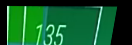

In [10]:
def random_perspective(img):
    # only apply to every n_th image
    if np.random.randint(3)!=0:
        return img
    MAX_CHANGE = 0.2
    a = np.random.rand(8).reshape(4,2)
    width, height = img.shape[:2]
    scale_factor = min(width,height)
    a = a*scale_factor*MAX_CHANGE
    pts1 = np.float32([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ])
    pts2 = np.float32([
        [0+a[0,0],0+a[0,1]],
        [width-a[1,0],0+a[1,1]],
        [width-a[2,0],height-a[2,1]],
        [0+a[3,0],height-a[3,1]]
    ])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img, M, (height,width))
    return img

path = file_list[1]
img = cv2.imread(path)
img = random_perspective(img)

Image.fromarray(img)

## Option 2

In [11]:
im_size = 48
ks = 5

mini_df = df

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.1,
    preprocessing_function = random_perspective
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

train_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=128, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=128, seed=42)

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:212: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  .format(self.class_mode))


Found 141356 validated image filenames.
Found 15706 validated image filenames.


### Define model

In [12]:
input_img = Input(shape=(im_size, im_size, 3))
# gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
conv1 = Conv2D(16, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
drop1 = Dropout(0.05)(conv1)
conv2 = Conv2D(16, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
drop2 = Dropout(0.05)(conv2)
# conv3 = Conv2D(32, (ks, ks), strides=2, padding='same', activation='relu')(drop2)
flat1  = Flatten()(drop2)
# dense1 = Dense(512,activation='relu')(flat1)
num1 = Dense(11,activation='softmax',name='num1')(flat1)
num2 = Dense(11,activation='softmax',name='num2')(flat1)
num3 = Dense(11,activation='softmax',name='num3')(flat1)
out = concatenate([num1,num2,num3],axis=1)

# output = keras.layers.concatenate([num1,num2,num3])
# output = [num1,num2,num3]?
model = Model(inputs = input_img, outputs=[num1,num2,num3])
model

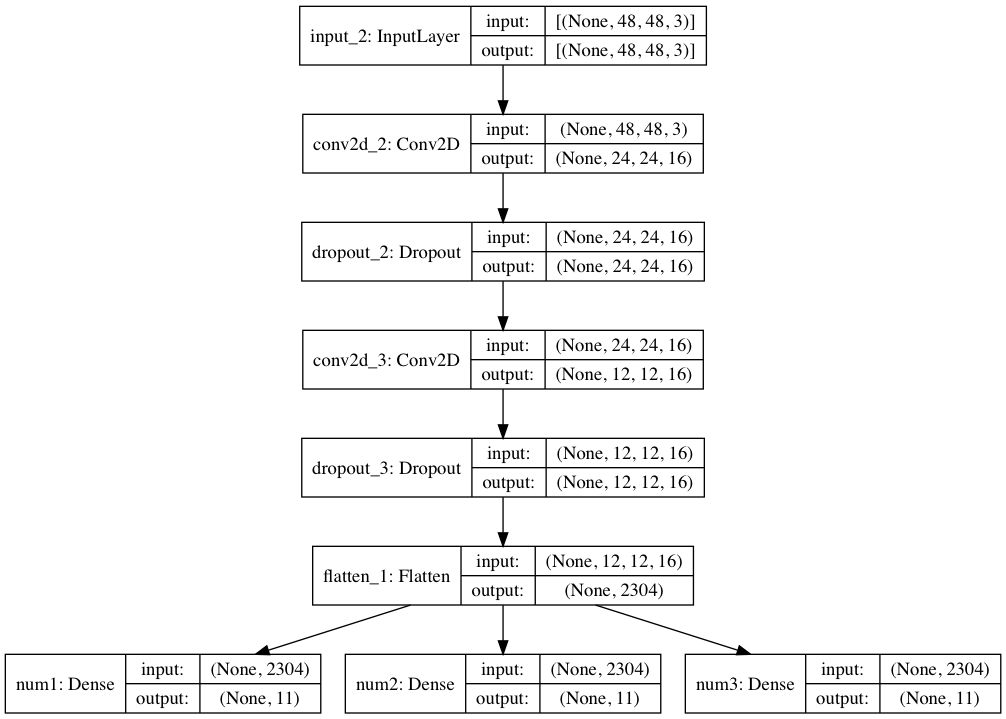

In [13]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 24, 24, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 12, 12, 16)   6416        dropout_2[0][0]                  
______________________________________________________________________________________________

In [15]:
model_name = 'dragon_mini_16'
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')
model_path = 'models'
all_checkpoint_path = f'{model_path}''/ep{epoch:02d}-va{val_loss:.2f}.hdf5'
save_all_callback = ModelCheckpoint(
        all_checkpoint_path, 
        monitor='val_loss',
        save_best_only=False,
    )

In [16]:
model.compile(optimizers.Adam(lr=0.001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"],)

In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1,
                    callbacks = [tensorboard, save_all_callback]
)

1104/1104 [==============================] - 414s 375ms/step - loss: 4.5434 - num1_loss: 0.5750 - num2_loss: 1.9263 - num3_loss: 2.0420 - num1_acc: 0.7560 - num2_acc: 0.3301 - num3_acc: 0.2791 - val_loss: 3.9402 - val_num1_loss: 0.2407 - val_num2_loss: 2.0792 - val_num3_loss: 1.6203 - val_num1_acc: 0.9173 - val_num2_acc: 0.2248 - val_num3_acc: 0.4951


In [ ]:
! ls